In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as npr

import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

import pandas as pd

np.random.seed(69420)


ModuleNotFoundError: No module named 'keras'

## Creating a dataset
We created a dataset which features a sine wave, a square and a circle to classify

In [60]:
def classify(a, b):
    r = 0
    if (b > np.sin(2 * a) + a) or (a > 8 and b < 2):
        r = 1
    if (a - 2) ** 2 + (b - 8) ** 2 < 1:
        r = 0
    return int(r)


In [61]:
N = 10000
X = 10 * npr.rand(N, 2)
y = np.zeros(N)
for i in range(N):
    y[i] = classify(X[i, 0], X[i, 1])


Text(0.5, 1.0, 'Data')

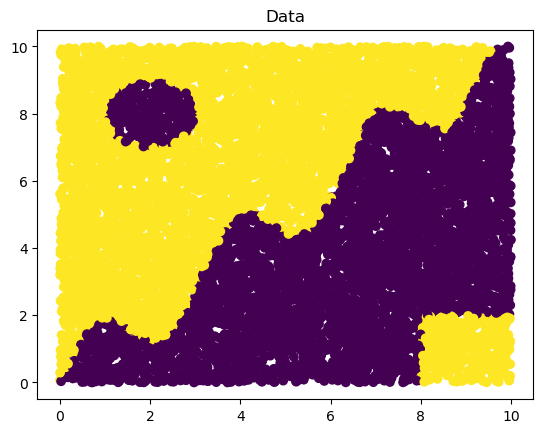

In [62]:
fig, AX = plt.subplots()

AX.scatter(X[:, 0], X[:, 1], c=y)
AX.set_title("Data")


In [76]:
permutation = np.random.permutation(X.shape[0])

train_percentage = 0.8
tsize = int(train_percentage * N)

X = X[permutation]
y = y[permutation]

X_train, X_valid = X[:tsize], X[tsize:]
y_train, y_valid = y[:tsize], y[tsize:]

labels, freqs = np.unique(Y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Labels in training dataset:  [0. 1.]
Frequencies in training dataset:  [3981 4019]


## DNN
We'll use as a starting point the model we optimnized for the first laboratory exercise

In [79]:
model = Sequential()
model.add(Dense(20, input_shape=(2,), activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(1, activation="sigmoid"))
nepoch = 400

print(model.summary())

model.compile(
    loss="binary_crossentropy",
    # optimizer='RMSprop',
    optimizer="adam",
    metrics=["accuracy"],
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 20)                60        
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                                                 
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,341
Trainable params: 1,341
Non-traina

In [80]:
fit = model.fit(
    X_train,
    y_train,
    epochs=nepoch,
    batch_size=50,
    validation_data=(X_valid, y_valid),
    verbose=1,
)


Epoch 1/400
160/160 [==============================] - 1s 1ms/step - loss: 0.4781 - accuracy: 0.8244 - val_loss: 0.3864 - val_accuracy: 0.8675
Epoch 2/400
160/160 [==============================] - 0s 869us/step - loss: 0.3345 - accuracy: 0.8735 - val_loss: 0.3222 - val_accuracy: 0.8750
Epoch 3/400
160/160 [==============================] - 0s 854us/step - loss: 0.2939 - accuracy: 0.8866 - val_loss: 0.3037 - val_accuracy: 0.8775
Epoch 4/400
160/160 [==============================] - 0s 808us/step - loss: 0.2759 - accuracy: 0.8923 - val_loss: 0.2767 - val_accuracy: 0.8880
Epoch 5/400
160/160 [==============================] - 0s 787us/step - loss: 0.2591 - accuracy: 0.9005 - val_loss: 0.2626 - val_accuracy: 0.8950
Epoch 6/400
160/160 [==============================] - 0s 785us/step - loss: 0.2471 - accuracy: 0.8980 - val_loss: 0.2807 - val_accuracy: 0.8835
Epoch 7/400
160/160 [==============================] - 0s 788us/step - loss: 0.2375 - accuracy: 0.8991 - val_loss: 0.2424 - val_accu

160/160 [==============================] - 0s 784us/step - loss: 0.1417 - accuracy: 0.9334 - val_loss: 0.1566 - val_accuracy: 0.9300
Epoch 58/400
160/160 [==============================] - 0s 771us/step - loss: 0.1381 - accuracy: 0.9352 - val_loss: 0.1650 - val_accuracy: 0.9240
Epoch 59/400
160/160 [==============================] - 0s 776us/step - loss: 0.1444 - accuracy: 0.9324 - val_loss: 0.1615 - val_accuracy: 0.9240
Epoch 60/400
160/160 [==============================] - 0s 777us/step - loss: 0.1409 - accuracy: 0.9345 - val_loss: 0.1452 - val_accuracy: 0.9350
Epoch 61/400
160/160 [==============================] - 0s 770us/step - loss: 0.1405 - accuracy: 0.9341 - val_loss: 0.1574 - val_accuracy: 0.9315
Epoch 62/400
160/160 [==============================] - 0s 776us/step - loss: 0.1359 - accuracy: 0.9384 - val_loss: 0.1583 - val_accuracy: 0.9220
Epoch 63/400
160/160 [==============================] - 0s 777us/step - loss: 0.1419 - accuracy: 0.9330 - val_loss: 0.1384 - val_accuracy

160/160 [==============================] - 0s 787us/step - loss: 0.1236 - accuracy: 0.9402 - val_loss: 0.1172 - val_accuracy: 0.9475
Epoch 114/400
160/160 [==============================] - 0s 771us/step - loss: 0.1182 - accuracy: 0.9455 - val_loss: 0.1289 - val_accuracy: 0.9400
Epoch 115/400
160/160 [==============================] - 0s 799us/step - loss: 0.1176 - accuracy: 0.9457 - val_loss: 0.1394 - val_accuracy: 0.9375
Epoch 116/400
160/160 [==============================] - 0s 774us/step - loss: 0.1242 - accuracy: 0.9420 - val_loss: 0.1740 - val_accuracy: 0.9235
Epoch 117/400
160/160 [==============================] - 0s 772us/step - loss: 0.1196 - accuracy: 0.9439 - val_loss: 0.1153 - val_accuracy: 0.9460
Epoch 118/400
160/160 [==============================] - 0s 769us/step - loss: 0.1183 - accuracy: 0.9438 - val_loss: 0.1228 - val_accuracy: 0.9410
Epoch 119/400
160/160 [==============================] - 0s 777us/step - loss: 0.1254 - accuracy: 0.9405 - val_loss: 0.1169 - val_ac

Epoch 169/400
160/160 [==============================] - 0s 784us/step - loss: 0.1140 - accuracy: 0.9461 - val_loss: 0.1191 - val_accuracy: 0.9425
Epoch 170/400
160/160 [==============================] - 0s 766us/step - loss: 0.1070 - accuracy: 0.9516 - val_loss: 0.1013 - val_accuracy: 0.9510
Epoch 171/400
160/160 [==============================] - 0s 771us/step - loss: 0.1045 - accuracy: 0.9545 - val_loss: 0.1195 - val_accuracy: 0.9510
Epoch 172/400
160/160 [==============================] - 0s 774us/step - loss: 0.1044 - accuracy: 0.9531 - val_loss: 0.1062 - val_accuracy: 0.9485
Epoch 173/400
160/160 [==============================] - 0s 774us/step - loss: 0.0988 - accuracy: 0.9560 - val_loss: 0.1152 - val_accuracy: 0.9485
Epoch 174/400
160/160 [==============================] - 0s 772us/step - loss: 0.1028 - accuracy: 0.9511 - val_loss: 0.1155 - val_accuracy: 0.9400
Epoch 175/400
160/160 [==============================] - 0s 771us/step - loss: 0.1021 - accuracy: 0.9538 - val_loss: 0

Epoch 225/400
160/160 [==============================] - 0s 776us/step - loss: 0.0686 - accuracy: 0.9746 - val_loss: 0.0617 - val_accuracy: 0.9775
Epoch 226/400
160/160 [==============================] - 0s 775us/step - loss: 0.0637 - accuracy: 0.9758 - val_loss: 0.0594 - val_accuracy: 0.9740
Epoch 227/400
160/160 [==============================] - 0s 772us/step - loss: 0.0589 - accuracy: 0.9779 - val_loss: 0.0565 - val_accuracy: 0.9810
Epoch 228/400
160/160 [==============================] - 0s 771us/step - loss: 0.0665 - accuracy: 0.9741 - val_loss: 0.0662 - val_accuracy: 0.9730
Epoch 229/400
160/160 [==============================] - 0s 771us/step - loss: 0.0665 - accuracy: 0.9756 - val_loss: 0.0542 - val_accuracy: 0.9820
Epoch 230/400
160/160 [==============================] - 0s 770us/step - loss: 0.0582 - accuracy: 0.9776 - val_loss: 0.0868 - val_accuracy: 0.9695
Epoch 231/400
160/160 [==============================] - 0s 776us/step - loss: 0.0678 - accuracy: 0.9750 - val_loss: 0

Epoch 281/400
160/160 [==============================] - 0s 776us/step - loss: 0.0526 - accuracy: 0.9824 - val_loss: 0.0450 - val_accuracy: 0.9870
Epoch 282/400
160/160 [==============================] - 0s 768us/step - loss: 0.0501 - accuracy: 0.9821 - val_loss: 0.0404 - val_accuracy: 0.9860
Epoch 283/400
160/160 [==============================] - 0s 770us/step - loss: 0.0567 - accuracy: 0.9785 - val_loss: 0.0486 - val_accuracy: 0.9820
Epoch 284/400
160/160 [==============================] - 0s 773us/step - loss: 0.0481 - accuracy: 0.9835 - val_loss: 0.0408 - val_accuracy: 0.9870
Epoch 285/400
160/160 [==============================] - 0s 769us/step - loss: 0.0506 - accuracy: 0.9818 - val_loss: 0.0404 - val_accuracy: 0.9885
Epoch 286/400
160/160 [==============================] - 0s 771us/step - loss: 0.0477 - accuracy: 0.9837 - val_loss: 0.0380 - val_accuracy: 0.9885
Epoch 287/400
160/160 [==============================] - 0s 782us/step - loss: 0.0523 - accuracy: 0.9799 - val_loss: 0

Epoch 337/400
160/160 [==============================] - 0s 782us/step - loss: 0.0367 - accuracy: 0.9885 - val_loss: 0.0537 - val_accuracy: 0.9775
Epoch 338/400
160/160 [==============================] - 0s 770us/step - loss: 0.0421 - accuracy: 0.9846 - val_loss: 0.0342 - val_accuracy: 0.9860
Epoch 339/400
160/160 [==============================] - 0s 774us/step - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.0353 - val_accuracy: 0.9845
Epoch 340/400
160/160 [==============================] - 0s 774us/step - loss: 0.0433 - accuracy: 0.9839 - val_loss: 0.0783 - val_accuracy: 0.9660
Epoch 341/400
160/160 [==============================] - 0s 773us/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.0338 - val_accuracy: 0.9875
Epoch 342/400
160/160 [==============================] - 0s 773us/step - loss: 0.0477 - accuracy: 0.9831 - val_loss: 0.0625 - val_accuracy: 0.9745
Epoch 343/400
160/160 [==============================] - 0s 770us/step - loss: 0.0482 - accuracy: 0.9810 - val_loss: 0

Epoch 393/400
160/160 [==============================] - 0s 784us/step - loss: 0.0348 - accuracy: 0.9876 - val_loss: 0.0529 - val_accuracy: 0.9780
Epoch 394/400
160/160 [==============================] - 0s 772us/step - loss: 0.0453 - accuracy: 0.9834 - val_loss: 0.0422 - val_accuracy: 0.9805
Epoch 395/400
160/160 [==============================] - 0s 772us/step - loss: 0.0372 - accuracy: 0.9844 - val_loss: 0.0324 - val_accuracy: 0.9865
Epoch 396/400
160/160 [==============================] - 0s 770us/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.0365 - val_accuracy: 0.9865
Epoch 397/400
160/160 [==============================] - 0s 774us/step - loss: 0.0369 - accuracy: 0.9870 - val_loss: 0.0311 - val_accuracy: 0.9880
Epoch 398/400
160/160 [==============================] - 0s 783us/step - loss: 0.0418 - accuracy: 0.9837 - val_loss: 0.0554 - val_accuracy: 0.9755
Epoch 399/400
160/160 [==============================] - 0s 768us/step - loss: 0.0419 - accuracy: 0.9844 - val_loss: 0

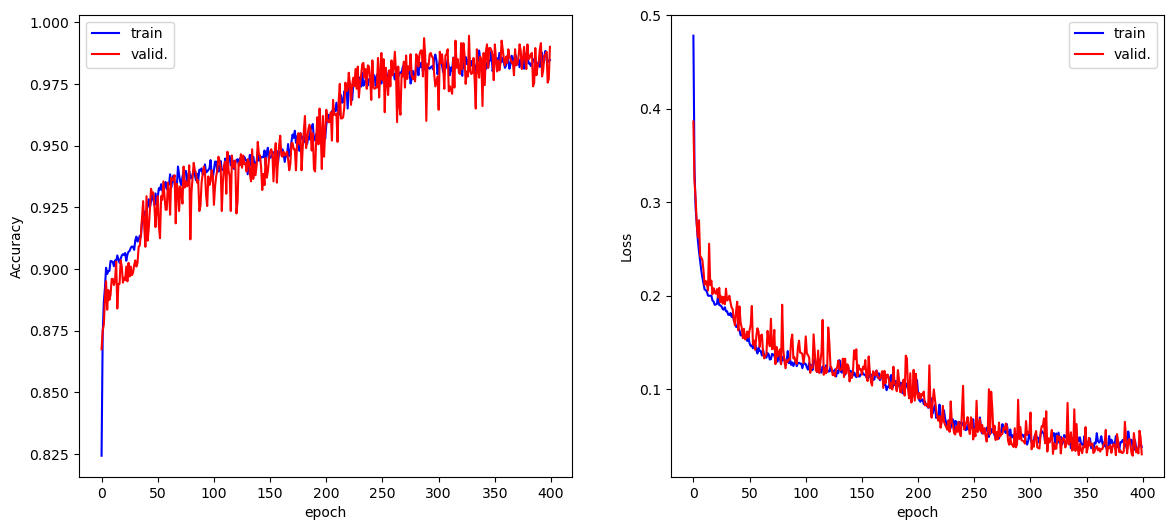

In [81]:
fig, AX = plt.subplots(1, 2, figsize=(14, 6.0))
ax = AX[0]
ax.plot(fit.history["accuracy"], label="train", c="b")
ax.plot(fit.history["val_accuracy"], label="valid.", c="r")
ax.set_xlabel("epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax = AX[1]
ax.plot(fit.history["loss"], label="train", c="b")
ax.plot(fit.history["val_loss"], label="valid.", c="r")
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.legend()


In [86]:
v = np.linspace(0, 10, 1000)
grid = 10 * npr.rand(N, 2)
# grid = np.reshape(np.meshgrid(v,v), (1000,1000,2))
pred = model.predict(grid)


313/313 [==============================] - 0s 394us/step


<function matplotlib.pyplot.show(close=None, block=None)>

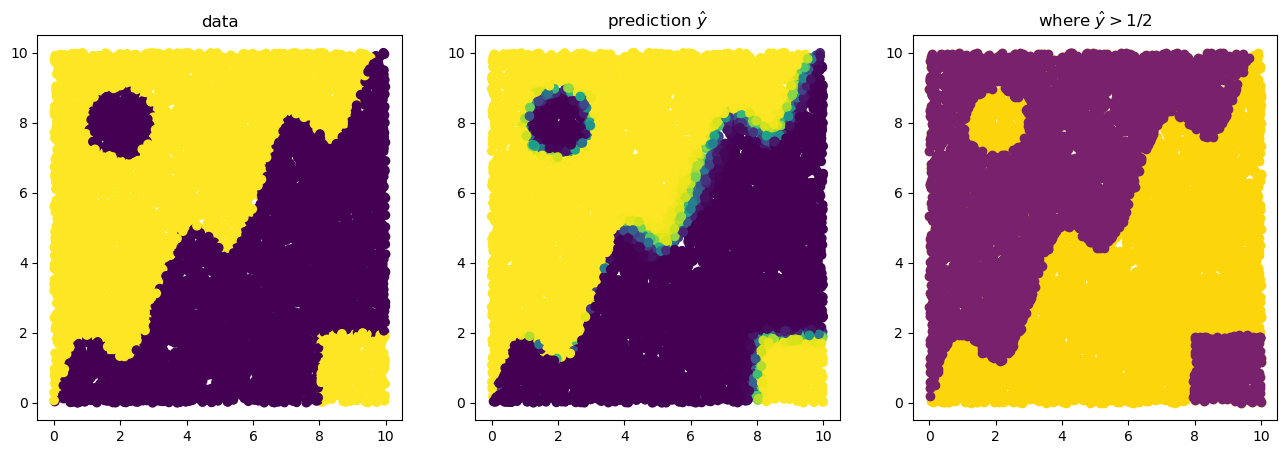

In [89]:
fig, AX = plt.subplots(1, 3, figsize=(16, 5.0))
ax = AX[0]
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_title("data")
ax = AX[1]
ax.scatter(grid[:, 0], grid[:, 1], c=pred)
ax.set_title("prediction $\\hat y$")
ax = AX[2]
W1 = np.where(pred > 0.5)[0]
ax.scatter(grid[:, 0], grid[:, 1], c="#FDD50B")
ax.scatter(grid[W1, 0], grid[W1, 1], c="#78226D")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show
